## Model Prediction after 2018 results

In [27]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [61]:
import pandas as pd
import numpy as np
from patsy import dmatrices
from sklearn.linear_model import LinearRegression, LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-deep')

In [130]:
data = pd.read_csv('results_2017_2018.csv')

In [131]:
# compute total points
data['points_total'] = data['points_televoting'] + data['points_jury']

In [132]:
# compute rank columns
data['rank_total'] = data.groupby('round')['points_total'].rank(ascending=False)
data['rank_jury'] = data.groupby('round')['points_jury'].rank(ascending=False)
data['rank_televoting'] = data.groupby('round')['points_televoting'].rank(ascending=False)

# check if points are set correctly (0 is correct) (there might be countries with rank_calc = X.5 in case of tie)
sum(abs(data['rank_source'] - data['rank_total']))

1.0

### Explore data

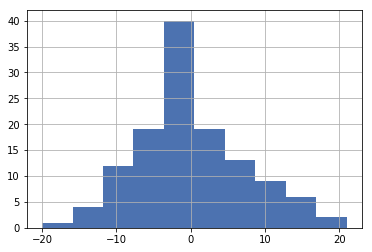

In [133]:
# difference between ranks from jury and televoting
data['rank_diff'] = data['rank_televoting'] - data['rank_jury']
(data['rank_diff']).hist(bins=10)

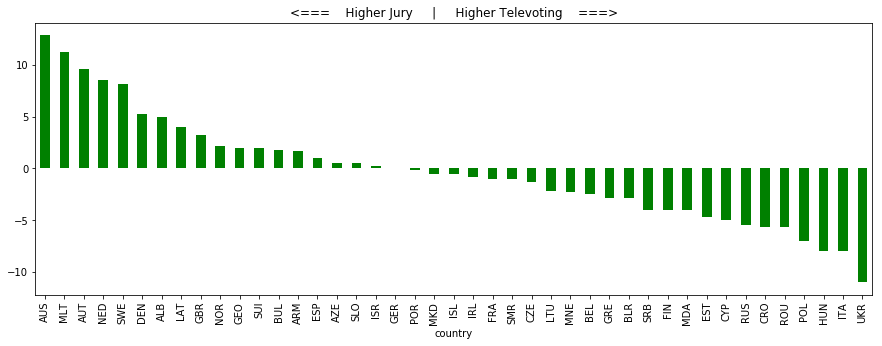

In [134]:
# which countries suffer more differences?
data.groupby('country')['rank_diff'].agg('mean').sort_values(ascending=False).plot.bar(color='green', 
                                                                                       title='<===    Higher Jury     |     Higher Televoting    ===>', 
                                                                                       figsize=(15,5))


Text(0.5,1,'<=== Higher in semifinal | Higher in final ===>')

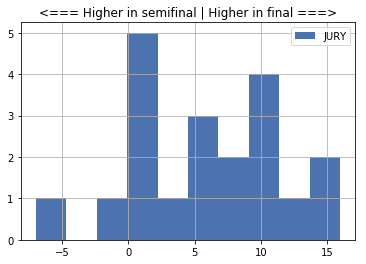

In [135]:
# compare jury votes/rank in semifinal vs final

data_final = data[data['round']=='2018_final']
data_semifinals = data[(data['round']=='2018_semi1') | (data['round']=='2018_semi2')]

# join data
data_merged = pd.merge(data_final, data_semifinals, left_on='country', right_on='country', how='inner', suffixes=('_f','_sf'))

# plot histogram
ax = (data_merged['rank_jury_f'] - data_merged['rank_jury_sf']).hist(label='JURY')
#(data_merged['rank_televoting_f'] - data_merged['rank_televoting_sf']).hist(label='TELE', ax=ax)
ax.legend()
ax.set_title('<=== Higher in semifinal | Higher in final ===>')

## Feature Engineering

In [138]:
#data.groupby('round')['positive'] / 
data.groupby('round')['positive'].agg('sum')


round
2017_final     9183
2017_semi1     1057
2017_semi2     6794
2018_final    11207
2018_semi1     8735
2018_semi2     7402
Name: positive, dtype: int64

In [ ]:
# add percentages of features over the totals
data['positive_perc'] = data['positive'] / data['positive'].sum()
data['negative_perc'] = data['negative'] / all_rounds_data['negative'].sum()
data['neutral_perc'] = data['neutral'] / all_rounds_data['neutral'].sum()
data['tweets_perc'] = data['tweets'] / all_rounds_data['tweets'].sum()

# create log features
all_rounds_data['negative_log'] = np.log(1 + all_rounds_data['negative'])
all_rounds_data['neutral_log'] = np.log(1 + all_rounds_data['neutral'])
all_rounds_data['positive_log'] = np.log(1 + all_rounds_data['positive'])
all_rounds_data['tweets_log'] = np.log(1 + all_rounds_data['tweets'])

# create label 'isTopN'
all_rounds_data['isTop5'] = all_rounds_data.apply(lambda r: 1 if r['rank']<=5 else 0, axis=1)
all_rounds_data['isTop10'] = all_rounds_data.apply(lambda r: 1 if r['rank']<=10 else 0, axis=1)

In [129]:
data.head(1)

,round,country,rank_source,points_televoting,points_jury,tweets,tweets_positive,tweets_neutral,tweets_negative,points_total,rank_total,rank_jury,rank_televoting,rank_diff
0,2017_final,POR,1,376,382,3377,833,138,786.0,758,1.0,1.0,1.0,0.0
